In [1]:
from AdnGAN import Generator,Discriminator,initialize_weights,get_loader,gradient_penalty #My package for GANs

import torch
from torch import optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

c:\Users\pc\scoop\apps\python\current\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Models

In [2]:
im_s = 128
ggg = Generator(channels_img=1,image_size=im_s)
ddd = Discriminator(channels_img=1,image_size=im_s)

t = torch.rand(1,100,1,1)
ou = ggg(t)
print(ou.shape)
ddd(ou).shape

torch.Size([1, 1, 128, 128])


torch.Size([1, 1, 1, 1])

# Hyperparameters

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
CHANNELS_IMG = 1
IMAGE_SIZE = 128
NUM_EPOCHS = 50
NOISE_DIM = 100
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10


# DATAset and datalaoder

In [4]:
dataloader = get_loader("../Drive_data/seg",CHANNELS_IMG,IMAGE_SIZE,BATCH_SIZE)

In [5]:
def visualize_bw_image(image):
    # Reshape the image to remove the singleton dimension if present
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image.squeeze()

    # Display the image
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.show()

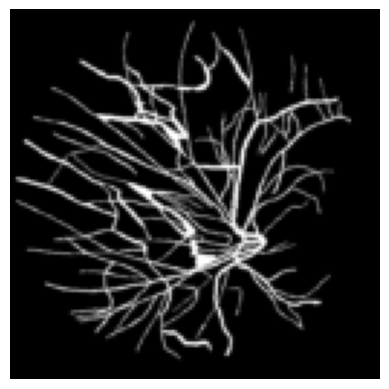

torch.Size([1, 128, 128])


In [6]:
for a in dataloader:
    visualize_bw_image(a[0])
    print(a[0].shape)
    break

# Training

In [7]:
gen = Generator(channels_img=CHANNELS_IMG,image_size=IMAGE_SIZE).to(device)
critic = Discriminator(channels_img=CHANNELS_IMG,image_size=IMAGE_SIZE).to(device)

initialize_weights(gen)
initialize_weights(critic)


opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE,betas=(0.0,0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE,betas=(0.0,0.9))

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()
print()

In [8]:
gen = Generator(channels_img=1,image_size=128).to(device)
gen(fixed_noise).shape

torch.Size([32, 1, 128, 128])

In [ ]:
for epoch in range(NUM_EPOCHS):
    for batch_idx,real in enumerate(dataloader):
        real = real.to(device)

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            #gradient penalty
            gp = gradient_penalty(critic,real,fake,device=device)

            loss_critic = (
                -(torch.mean(critic_real)-torch.mean(critic_fake))+LAMBDA_GP*gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        ### Train Generator: min E(critic(gen_fake))
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

In [ ]:
#torch.save(gen.state_dict(), ".\gen_64_rgb_wgan_gp______.pth")

torch.Size([1, 1, 128, 128])


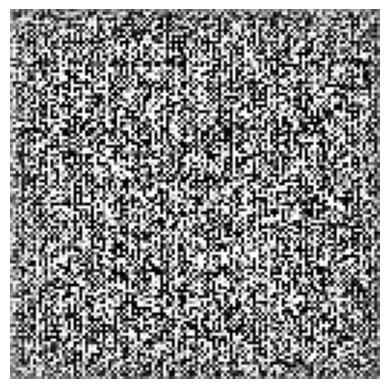

In [10]:
noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
g = gen(noise)
print(g.shape)
pic = g[0].cpu().detach().numpy().transpose(1, 2, 0)

visualize_bw_image(pic)

---